### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

### Solution

First of all we give a full specification of the model we're going to study:

$$\begin{align}
X &\sim \mathcal{N}(\mu_x,\sigma_x)\\
\theta_1 &\sim \mathcal{N}(\mu_1,\sigma_1)\\
\theta_2 &\sim \mathcal{N}(\mu_2,\sigma_2)\\
\end{align}$$

where $\mu_x,\sigma_x,\mu_1,\sigma_1,\mu_2,\sigma_2,$ are the hyperparameters of the model and $Y=f(X|\theta_1,\theta_2)$ as specified the exercise text.

A BN representation of the model follows



The following implementation of the model takes the hyperparameters as inputs.

In [2]:
# import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC

In [3]:
# Define the model
def model(mu_x=200,std_x=100,
          mu_1=0,std_1=10,
          mu_2=0,std_2=10):
    
    # x ~ N(mu_x, var_x)
    x = pyro.sample("x", dist.Normal(mu_x,std_x))
    
    # theta_i ~ N(mu_thi,var_thi)
    theta1 = pyro.sample("theta1", dist.Normal(mu_1,std_1))
    theta2 = pyro.sample("theta2", dist.Normal(mu_2,std_2))
    
    # compute y
    y = pyro.param("y", theta1*x/(theta2+x))
    #y = theta1*x/(theta2+x)
    return y


In order to estimate the posteriors $p(\theta_1|x,y)$ and $p(\theta_2|x,y)$ we will adopt HMC to produce several approximated sampling of the model conditioned over the given observations of $x$ and $y$.

We first define the conditioned model:

In [4]:
# Define the conditioned model
obss={
    "x":torch.tensor([28,55,110,138,225,375]),
    "y":torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122])
     }
conditioned_model =pyro.condition(model,data=obss)

We will repeat the process using different values for the model's hyperparameters concerning $\theta_1$ and $\theta_2$ (that is, $\mu_1, \sigma_1, \mu_2$ and $\sigma_2$) and varying the parameters of the HMC simulation (warm-up steps, number of samples, number of chains).
We may as well ignore $X$'s distribution parameters $\mu_X,\sigma_X$, since it is an observed variable.

To begin with, let's compute a reference HMC run and investigate its statistics to determine where to begin with our hyperparameter space exploration.

In [5]:
# setup HMC
pyro.set_rng_seed(777)
mcmc_samples = 200
mcmc_warmup = 400
mcmc_chains = 4
mcmc= MCMC(HMC(model=conditioned_model),
          num_samples = mcmc_samples,
          warmup_steps = mcmc_warmup,
          num_chains = mcmc_chains)

mcmc.run() #mu_1 = mu_2 = 0, std_1 = std_2 = 10

c:\winvenv\lib\site-packages\pyro\infer\mcmc\api.py:336: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  .format(num_chains, available_cpu))
Sample [3]: 100%|█████████████████████████████████████| 600/600 [00:11, 51.29it/s, step size=9.07e-01, acc. prob=0.923]


dict_keys(['theta1', 'theta2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.35      9.84     -0.20    -16.18     15.50    432.64      1.01
    theta2     -1.02      9.99     -0.86    -18.04     14.62    284.80      1.01

Number of divergences: 0


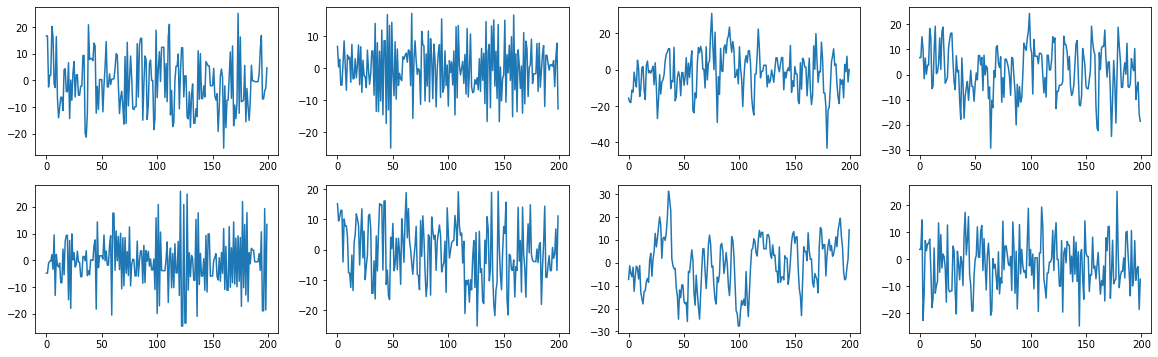

In [6]:
# investigate statistics
keys = mcmc.get_samples().keys()
print(keys)
samples = mcmc.get_samples(group_by_chain=True)

# plot all the chains
fig,ax = plt.subplots(2,mcmc_chains,figsize=(20,6))
for iii, kkk in enumerate(keys):
    for jjj, ccc in enumerate(range(mcmc_chains)):
        sns.lineplot(x=range(mcmc_samples),
                     y=samples[kkk][ccc],
                     ax = ax[iii][jjj])
        
mcmc.summary()

From the summary we can see $\hat R$ is very close to 1 and $n_{\text{eff}}$ is high for both parameters, suggesting that HMC stationarity was reached. Looks like a lucky start! 

Let's look at samples distribution by considering an incremental number of already computed chains, to get a sense on how this parameter influences the distribution

Chain Count:	 1  ( 200  samples) 
mean theta_1:	 -0.967193067073822 
mean theta_2:	 -0.6739261150360107 

Chain Count:	 2  ( 400  samples) 
mean theta_1:	 -0.5087475776672363 
mean theta_2:	 -0.7366487979888916 

Chain Count:	 3  ( 600  samples) 
mean theta_1:	 -0.9281819462776184 
mean theta_2:	 -0.7880608439445496 

Chain Count:	 4  ( 800  samples) 
mean theta_1:	 -0.3460525572299957 
mean theta_2:	 -1.017929196357727 



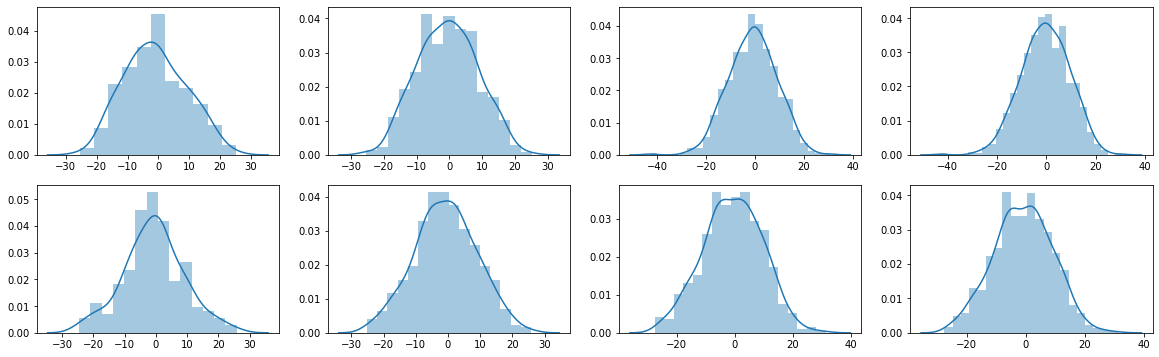

In [7]:
# print expected means for incrementing number of chains
for iii in range(1,mcmc_chains+1):
    print("Chain Count:\t",iii,
          " (", mcmc_samples * iii, " samples)", 
          "\nmean theta_1:\t",
          samples['theta1'][0:iii].mean().item(),
          "\nmean theta_2:\t",
          samples['theta2'][0:iii].mean().item(),"\n")
    
#graph estimated densities for different chain numbers
fig,ax = plt.subplots(2,mcmc_chains,figsize=(20,6))
for iii, kkk in enumerate(keys):
    for jjj in range(mcmc_chains):
        sns.distplot(samples[kkk][0:jjj+1],
                     ax = ax[iii][jjj])

It's apparent from the graphs that the more chains we consider, the more the sampled distribution gets to resemble the prior gaussians used in the model.

Let's see if this holds when we fiddle with $\mu_1,\mu_2,\sigma_1,\sigma_2$:

In [8]:
#define another HMC model
pyro.set_rng_seed(777)

mcmc2= MCMC(HMC(model=conditioned_model),
          num_samples = mcmc_samples,
          warmup_steps = mcmc_warmup,
          num_chains = mcmc_chains)

#this time we change prior's parameters
mcmc2.run(mu_1=10,std_1=2,
          mu_2=-2,std_2=20)

c:\winvenv\lib\site-packages\pyro\infer\mcmc\api.py:336: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  .format(num_chains, available_cpu))
Sample [3]: 100%|█████████████████████████████████████| 600/600 [00:12, 48.83it/s, step size=9.22e-01, acc. prob=0.935]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      9.71      2.05      9.53      6.98     13.45     72.76      1.06
    theta2     -4.49     19.81     -3.14    -39.12     24.72     45.05      1.11

Number of divergences: 0


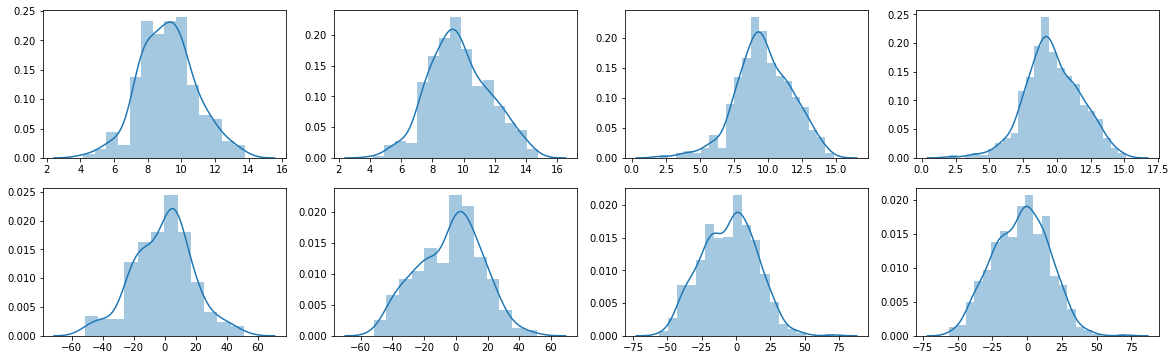

In [9]:
#summary
mcmc2.summary()

#graph estimated densities for different chain numbers
samples2 = mcmc2.get_samples(group_by_chain=True)

fig,ax = plt.subplots(2,mcmc_chains,figsize=(20,6))
for iii, kkk in enumerate(samples2.keys()):
    for jjj in range(mcmc_chains):
        sns.distplot(samples2[kkk][0:jjj+1],
                     ax = ax[iii][jjj])

All in all we can see our assumption holds, even if $\theta_2$'s resemblance of the prior is a bit less tighter, probably due to the higher variance.
Both $\hat R$ and $n_{\text{eff}}$ have worsened.

Let's see if we can improve on these by varying the chains' lengths:

c:\winvenv\lib\site-packages\pyro\infer\mcmc\api.py:336: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  .format(num_chains, available_cpu))
Sample [3]: 100%|███████████████████████████████████| 1200/1200 [00:23, 50.44it/s, step size=8.27e-01, acc. prob=0.951]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      9.44      2.14      9.09      6.45     12.93      8.49      1.22
    theta2     -0.84     17.32     -1.88    -33.46     24.36    132.21      1.05

Number of divergences: 0


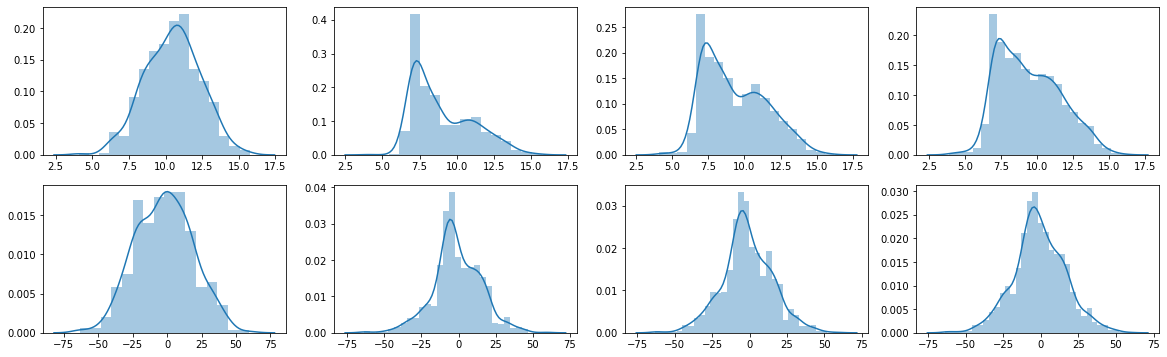

In [10]:
#setup and simulation
pyro.set_rng_seed(777)

mcmc_warmup = 800
mcmc_chains = 4
mcmc_samples = 400

mcmc3= MCMC(HMC(model=conditioned_model),
          num_samples = mcmc_samples,
          warmup_steps = mcmc_warmup,
          num_chains = mcmc_chains)

mcmc3.run(mu_1=10,std_1=2,
          mu_2=-2,std_2=20)

#summary
mcmc3.summary()

#graph estimated densities for different chain numbers
samples3 = mcmc3.get_samples(group_by_chain=True)

fig,ax = plt.subplots(2,mcmc_chains,figsize=(20,6))
for iii, kkk in enumerate(samples3.keys()):
    for jjj in range(mcmc_chains):
        sns.distplot(samples3[kkk][0:jjj+1],
                     ax = ax[iii][jjj])

$\theta_1$'s mean and std remained more or less unarmed, although its posterior doesn't look gaussian anymore, and indicators suggest stationarity is severely impaired.  
$\theta_2$'s posterior's become more peaked and its indicators has slightly improved.  
For sake of completeness let's see the effect of reducing the chains' length.

c:\winvenv\lib\site-packages\pyro\infer\mcmc\api.py:336: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  .format(num_chains, available_cpu))
Sample [3]: 100%|█████████████████████████████████████| 150/150 [00:03, 46.86it/s, step size=4.76e-01, acc. prob=0.978]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      9.39      2.41      9.85      4.56     12.12      7.03      1.36
    theta2     -4.90     17.06     -6.25    -30.05     21.60    144.05      1.04

Number of divergences: 0


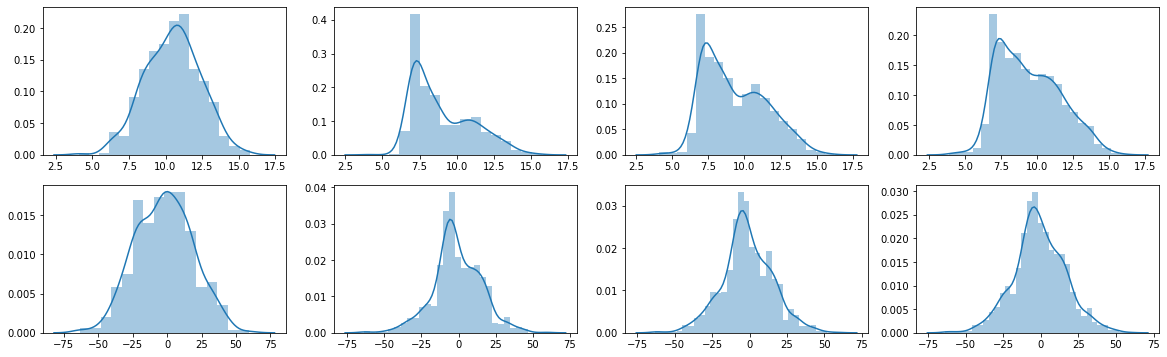

In [11]:
#setup and simulation
pyro.set_rng_seed(777)

mcmc_warmup = 100
mcmc_chains = 4
mcmc_samples = 50

mcmc4= MCMC(HMC(model=conditioned_model),
          num_samples = mcmc_samples,
          warmup_steps = mcmc_warmup,
          num_chains = mcmc_chains)

mcmc4.run(mu_1=10,std_1=2,
          mu_2=-2,std_2=20)

#summary
mcmc4.summary()

#graph estimated densities for different chain numbers
samples4 = mcmc4.get_samples(group_by_chain=True)

fig,ax = plt.subplots(2,mcmc_chains,figsize=(20,6))
for iii, kkk in enumerate(samples4.keys()):
    for jjj in range(mcmc_chains):
        sns.distplot(samples3[kkk][0:jjj+1],
                     ax = ax[iii][jjj])

Now $\theta_1$'s statistic are getting even worse while $\theta_2$ is actually improving, which is somewhat unexpected, and could be explained by the fact that the higher prior variance is more accomodating.  

Once again we see that $\theta_1$'s peak is trying to move towards 0, while $\theta_2$'s is happily sitting close to the original prior.
We may conclude from these tests that our original choice of the hyperparameters was more apprioriate for this model, therefore we'll stick with it.  

Finally let's see if we can improve our sample distributions by repeating our first test, but sampling more chains:

In [12]:
# setup HMC
pyro.set_rng_seed(777)
mcmc_samples = 200
mcmc_warmup = 400
mcmc_chains = 8
mcmc5= MCMC(HMC(model=conditioned_model),
          num_samples = mcmc_samples,
          warmup_steps = mcmc_warmup,
          num_chains = mcmc_chains)

mcmc5.run()

mcmc5.summary()

c:\winvenv\lib\site-packages\pyro\infer\mcmc\api.py:336: UserWarning: num_chains=8 is more than available_cpu=1. Chains will be drawn sequentially.
  .format(num_chains, available_cpu))
Sample [7]: 100%|█████████████████████████████████████| 600/600 [00:11, 52.99it/s, step size=8.88e-01, acc. prob=0.974]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.98      9.06     -1.24    -16.77     12.64    135.88      1.07
    theta2     -1.15      9.73     -1.79    -16.51     14.82    256.34      1.02

Number of divergences: 0


It turns out that both stationarity indicator worsened, so we were indeed lucky in our first run.

We'll call that final.  
Here's a final plot of the posteriors, as for the results of our first HMC simulation:

Text(0.5, 1.0, '$p(theta_2|x,y)$')

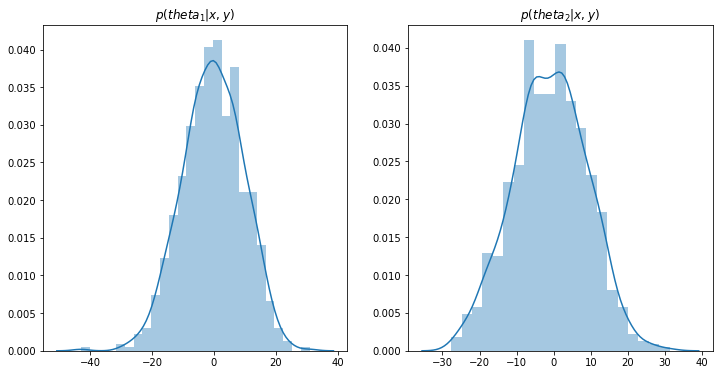

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(samples["theta1"], ax=ax[0])
sns.distplot(samples["theta2"], ax=ax[1])
ax[0].set_title("$p(theta_1|x,y)$")
ax[1].set_title("$p(theta_2|x,y)$")

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|y,x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|y,x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|y,x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

### Solution

My initial hope was finding a way to define a bivariate gaussian `dist` and condition it explicitly using an appropriate pyro call. Unfortunately I wasn't able to find a way to do that, therefore I'll be hardcoding the following theoretical result inside of my implementation of the gibbs sampler:  
given
$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {\mu_1 \choose \mu_2} , \begin{pmatrix} \sigma_1 & \rho \\ \rho & \sigma_2 \end{pmatrix} \Bigg],
$$
then
$$ p(x_1|x_2) = \mathcal{N}\left(\mu_1 + \rho\frac{\sigma_1}{\sigma_2}(x_2-\mu_2), \sigma_1\sqrt{1-\rho^2}\right).
$$

In our case we assume $\sigma_1=\sigma_2=1$, hence the standard deviation is equal for both conditioned probabilities.

The implementation follows:

In [14]:
def binormalgibbs(warmup,iters,
                rho,
                means=torch.tensor([0,0])):
    
    # compute shared conditionals' stdev  
    std_c = np.sqrt(1-rho*rho)
    
    #initialize output vector with means in 0th position
    output = torch.zeros([iters,2])
    output[0]=means
    
    
    #perform warmup steps in position [0,0].
    #Last warmup step is actually first sample
    for iii in range(warmup+1):
        mu_c1 = means[0] + rho*(output[0,1] - means[1])
        output[0,0] = pyro.sample("x1_0",dist.Normal(mu_c1,std_c))
        
        mu_c2 = means[1] + rho*(output[0,0] - means[0])
        output[0,1] = pyro.sample("x2_0",dist.Normal(mu_c2,std_c))
    
    for iii in range(1,iters):
        mu_c1 = means[0] + rho*(output[iii-1,1] - means[1])
        output[iii,0] = pyro.sample("x1_{}".format(iii),
                                  dist.Normal(mu_c1,std_c))
    
        mu_c2 = means[1] + rho*(output[iii,0] - means[0])
        output[iii,1] = pyro.sample("x2_{}".format(iii),
                                  dist.Normal(mu_c2,std_c))
        
    return output

Let's now test it on a bivariate gaussian centered on $(0,0)$ with $\rho=0.7$:

predicted x1:	 -0.036833007 
predicted x2:	 -0.0351429


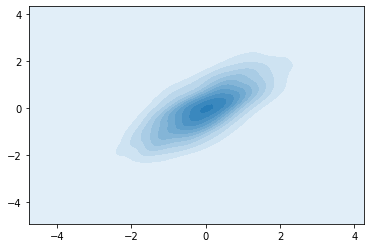

In [18]:
pyro.set_rng_seed(777)
samps = np.array(binormalgibbs(4000,2000,.7))

# plot
sns.kdeplot(samps[:,0],samps[:,1],shade=True)
#predicted means
print("predicted x1:\t",samps[:,0].mean(),
      "\npredicted x2:\t",samps[:,1].mean())

The plot shows that the sampling algorithm works as expected.

Let's do a final test applying it to a bivariate gaussian centered on our estimates of the $\theta$ parameters computed in the first exercise, using the function `np.corrcoef` to estimate the sample variance between the two vectors of samples of $\theta_1$ and $\theta_2$:

tensor([-0.3461, -1.0179]) 0.03768245404258108
predicted theta1:	 -0.36356533 
predicted theta2:	 -1.0316862


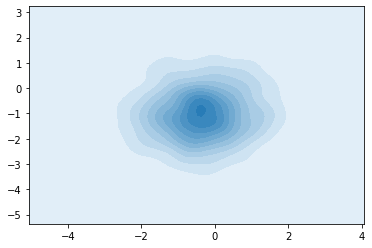

In [19]:
means = torch.tensor([samples['theta1'].mean(),
                     samples['theta2'].mean()])
rho = np.corrcoef(samples['theta1'].numpy().flatten(),
                  samples['theta2'].numpy().flatten())[0,1]

print(means, rho)

pyro.set_rng_seed(777)
samps = np.array(binormalgibbs(4000,2000,rho,means))

# plot
sns.kdeplot(samps[:,0],samps[:,1],shade=True)
print("predicted theta1:\t",samps[:,0].mean(),
      "\npredicted theta2:\t",samps[:,1].mean())

Once again the graph looks like expected, and indeed the new estimates are very close to the input means.